In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# For reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

pd.set_option("display.max_columns", None)


In [3]:
# Step 1: Data Collection (Google Colab)

# If you haven't uploaded the file yet:
# Go to the left sidebar → Files → Upload → select insurance_claims.csv

import pandas as pd

DATA_PATH = "/content/insurance_claims.csv"   # Colab path after uploading

df = pd.read_csv(DATA_PATH)

print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (1000, 40)


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,NaN,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


Dropping empty columns: ['_c39']
fraud_reported value counts before encoding:
fraud_reported
N    753
Y    247
Name: count, dtype: int64

fraud_reported value counts after encoding:
fraud_reported
0    753
1    247
Name: count, dtype: int64


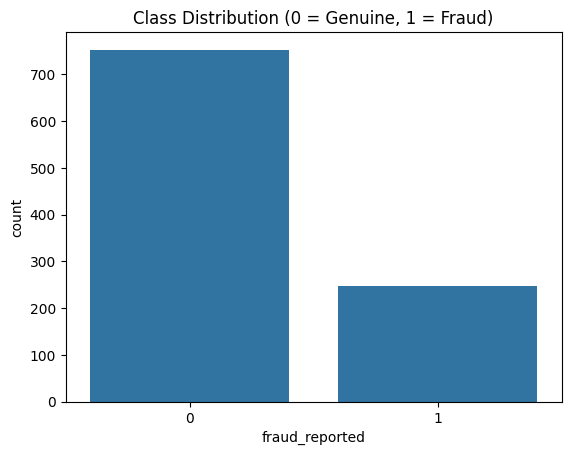

In [4]:
# Step 2: Initial Cleaning and Target Encoding

# Drop columns that are completely empty (some datasets have an empty `_c39` column)
empty_cols = [c for c in df.columns if df[c].isna().all()]
if empty_cols:
    print("Dropping empty columns:", empty_cols)
    df.drop(columns=empty_cols, inplace=True)

# Show target column value counts
print("fraud_reported value counts before encoding:")
print(df['fraud_reported'].value_counts())

# Encode target: Y → 1, N → 0
df['fraud_reported'] = df['fraud_reported'].map({'Y': 1, 'N': 0}).astype(int)

print("\nfraud_reported value counts after encoding:")
print(df['fraud_reported'].value_counts())

# Plot class distribution
sns.countplot(x=df['fraud_reported'])
plt.title("Class Distribution (0 = Genuine, 1 = Fraud)")
plt.show()


In [5]:
# Step 3: Define features (X) and target (y), and identify column types

TARGET_COL = "fraud_reported"

# Columns that are like IDs / dates / text not very useful for prediction
id_like_cols = [
    "policy_number",
    "policy_bind_date",
    "incident_date",
    "incident_location",
    "insured_zip",
    "policy_csl"   # coverage string like '100/300'
]

# Keep only columns that actually exist in df
id_like_cols = [c for c in id_like_cols if c in df.columns]

print("Dropping ID-like columns (if present):", id_like_cols)

# Split X and y
X = df.drop(columns=[TARGET_COL] + id_like_cols, errors="ignore")
y = df[TARGET_COL]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("\nNumeric features:")
print(numeric_features)

print("\nCategorical features:")
print(categorical_features)


Dropping ID-like columns (if present): ['policy_number', 'policy_bind_date', 'incident_date', 'incident_location', 'insured_zip', 'policy_csl']
Shape of X: (1000, 32)
Shape of y: (1000,)

Numeric features:
['months_as_customer', 'age', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'capital-gains', 'capital-loss', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_year']

Categorical features:
['policy_state', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'property_damage', 'police_report_available', 'auto_make', 'auto_model']


In [6]:
# Step 4: Preprocessing pipeline + train/test split

# Numeric pipeline: median imputation + scaling
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline: most_frequent imputation + one-hot encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Split into training and testing (stratify maintains fraud ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=SEED
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

print("\nTraining label distribution:")
print(y_train.value_counts())

print("\nTesting label distribution:")
print(y_test.value_counts())


Training set shape: (800, 32)
Testing set shape: (200, 32)

Training label distribution:
fraud_reported
0    602
1    198
Name: count, dtype: int64

Testing label distribution:
fraud_reported
0    151
1     49
Name: count, dtype: int64


In [7]:
# Step 5: Apply preprocessing and prepare data for neural networks

# Fit the preprocessor on training data and transform both train and test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Transformed training shape:", X_train_processed.shape)
print("Transformed testing shape:", X_test_processed.shape)

# Number of input features after one-hot encoding etc.
input_dim = X_train_processed.shape[1]
print("Input dimension for neural networks:", input_dim)


Transformed training shape: (800, 157)
Transformed testing shape: (200, 157)
Input dimension for neural networks: 157


In [8]:
# Step 6: Prepare data for Keras (dense arrays) + handle class imbalance

# ColumnTransformer often returns a sparse matrix; Keras prefers dense
if hasattr(X_train_processed, "toarray"):
    X_train_np = X_train_processed.toarray()
    X_test_np = X_test_processed.toarray()
else:
    X_train_np = X_train_processed
    X_test_np = X_test_processed

print("Dense training shape:", X_train_np.shape)
print("Dense testing shape:", X_test_np.shape)

# Compute class weights to deal with imbalance (fraud is minority)
classes = np.unique(y_train)
weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weights = dict(zip(classes, weights))

print("Class weights:", class_weights)


Dense training shape: (800, 157)
Dense testing shape: (200, 157)
Class weights: {np.int64(0): np.float64(0.6644518272425249), np.int64(1): np.float64(2.0202020202020203)}


In [9]:
# Step 7: Build ANN model

def build_ann(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid")  # binary output
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name="auc")]
    )
    return model

ann_model = build_ann(input_dim)
ann_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        10,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,225 (47.75 KB)

 Trainable params: 12,225 (47.75 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Step 8: Train ANN with early stopping

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_ann = ann_model.fit(
    X_train_np,
    y_train,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    class_weight=class_weights,
    verbose=1,
    callbacks=[early_stop]
)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.2711 - auc: 0.5935 - loss: 0.7108 - val_accuracy: 0.3250 - val_auc: 0.5054 - val_loss: 0.7803
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3775 - auc: 0.6683 - loss: 0.6740 - val_accuracy: 0.4250 - val_auc: 0.5219 - val_loss: 0.7278
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5352 - auc: 0.7138 - loss: 0.6530 - val_accuracy: 0.5562 - val_auc: 0.5338 - val_loss: 0.6940
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6723 - auc: 0.7506 - loss: 0.6381 - val_accuracy: 0.6062 - val_auc: 0.5502 - val_loss: 0.6728
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7295 - auc: 0.7825 - loss: 0.6238 - val_accuracy: 0.6062 - val_auc: 0.5668 - val_loss: 0.6603
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7604 - auc: 0.8102 - loss: 0.6083 - val_accuracy: 0.6062 - val_auc: 0.5824 - val_loss: 0.6536
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accura

In [11]:
# Step 9: Helper to print metrics

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

def print_metrics(y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")


In [12]:
# Step 10: Evaluate ANN on test set

# Predict probabilities and class labels
y_proba_ann = ann_model.predict(X_test_np).ravel()
y_pred_ann = (y_proba_ann >= 0.5).astype(int)

print("=== ANN performance on test set ===")
print_metrics(y_test, y_pred_ann, y_proba_ann)

print("\nClassification report:")
print(classification_report(y_test, y_pred_ann, zero_division=0))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
=== ANN performance on test set ===
Accuracy : 0.7350
Precision: 0.4583
Recall   : 0.4490
F1-score : 0.4536
ROC-AUC  : 0.7777

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       151
           1       0.46      0.45      0.45        49

    accuracy                           0.73       200
   macro avg       0.64      0.64      0.64       200
weighted avg       0.73      0.73      0.73       200



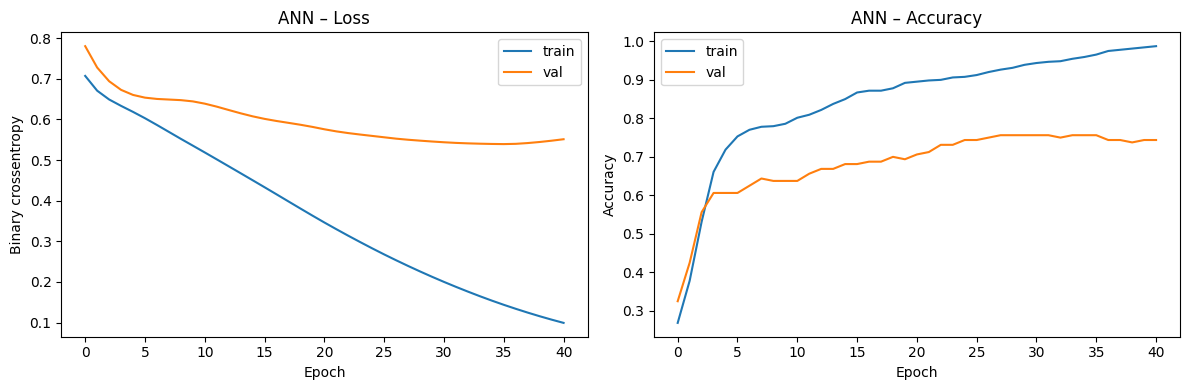

In [13]:
# Step 11: Plot ANN training curves

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history_ann.history["loss"], label="train")
axes[0].plot(history_ann.history["val_loss"], label="val")
axes[0].set_title("ANN – Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Binary crossentropy")
axes[0].legend()

# Accuracy
axes[1].plot(history_ann.history["accuracy"], label="train")
axes[1].plot(history_ann.history["val_accuracy"], label="val")
axes[1].set_title("ANN – Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()


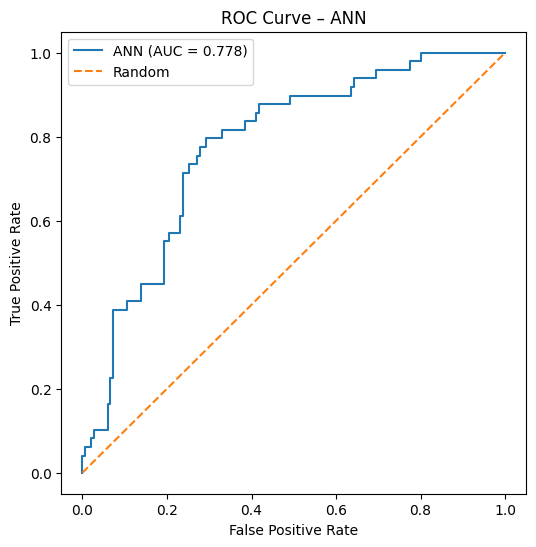

In [14]:
# Step 12: ROC curve for ANN

fpr, tpr, _ = roc_curve(y_test, y_proba_ann)
auc_ann = roc_auc_score(y_test, y_proba_ann)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ANN (AUC = {auc_ann:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – ANN")
plt.legend()
plt.show()


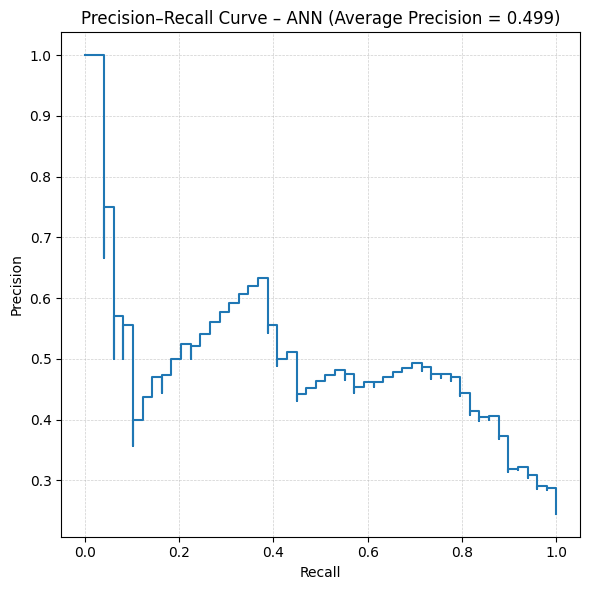

In [24]:
# Precision–Recall Curve for ANN

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# y_test and y_proba_ann are already defined from ANN evaluation
precision, recall, _ = precision_recall_curve(y_test, y_proba_ann)
avg_prec = average_precision_score(y_test, y_proba_ann)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where="post")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve – ANN (Average Precision = {avg_prec:.3f})")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


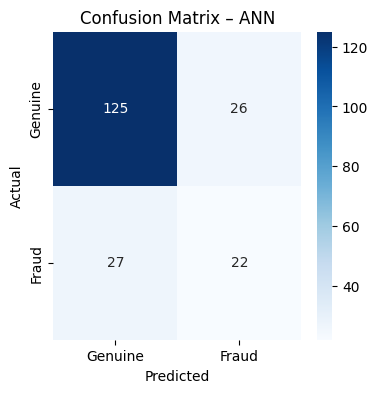

In [25]:
# Confusion matrix helper and plot

import seaborn as sns

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Genuine", "Fraud"],
                yticklabels=["Genuine", "Fraud"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_confusion(y_test, y_pred_ann, "Confusion Matrix – ANN")


In [16]:
# Step 13: Build Autoencoder for anomaly detection (train only on genuine claims)

# Use only non-fraud (label 0) claims for training
X_train_genuine = X_train_np[y_train == 0]

def build_autoencoder(input_dim):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(64, activation="relu")(inp)
    x = layers.Dense(32, activation="relu")(x)
    bottleneck = layers.Dense(16, activation="relu")(x)

    x = layers.Dense(32, activation="relu")(bottleneck)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(input_dim, activation="linear")(x)

    autoencoder = keras.Model(inp, out)
    autoencoder.compile(optimizer="adam", loss="mse")
    return autoencoder

ae_model = build_autoencoder(input_dim)
ae_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 157)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        10,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 157)            │        10,205 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,581 (99.93 KB)

 Trainable params: 25,581 (99.93 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Step 14: Train Autoencoder

early_stop_ae = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_ae = ae_model.fit(
    X_train_genuine,
    X_train_genuine,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop_ae],
    verbose=1
)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - loss: 0.2064 - val_loss: 0.2044
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.2041 - val_loss: 0.2026
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.2024 - val_loss: 0.2011
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.2009 - val_loss: 0.1996
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1993 - val_loss: 0.1981
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1975 - val_loss: 0.1964
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1956 - val_loss: 0.1945
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1935 - val_loss: 0.1925
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1913 - val_loss: 0.1906
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1890 - val_loss: 0.1886
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1868 - val_loss: 0.1866
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1846 - val_loss: 0.1844


In [18]:
# Step 15: Compute reconstruction error on genuine training claims

X_train_genuine_pred = ae_model.predict(X_train_genuine)
train_mse = np.mean(np.square(X_train_genuine - X_train_genuine_pred), axis=1)

# Choose threshold at 95th percentile of genuine reconstruction errors
threshold = np.percentile(train_mse, 95)
print("Chosen reconstruction error threshold:", threshold)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Chosen reconstruction error threshold: 0.1622872838480109


In [19]:
# Step 16: Reconstruction error on test set

X_test_pred = ae_model.predict(X_test_np)
test_mse = np.mean(np.square(X_test_np - X_test_pred), axis=1)

# Higher error => more anomalous => more likely fraud
y_pred_ae = (test_mse >= threshold).astype(int)  # 1 = fraud, 0 = genuine

print("=== Autoencoder performance on test set ===")
print_metrics(y_test, y_pred_ae, test_mse)

print("\nClassification report (Autoencoder):")
print(classification_report(y_test, y_pred_ae, zero_division=0))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
=== Autoencoder performance on test set ===
Accuracy : 0.7300
Precision: 0.3913
Recall   : 0.1837
F1-score : 0.2500
ROC-AUC  : 0.6291

Classification report (Autoencoder):
              precision    recall  f1-score   support

           0       0.77      0.91      0.84       151
           1       0.39      0.18      0.25        49

    accuracy                           0.73       200
   macro avg       0.58      0.55      0.54       200
weighted avg       0.68      0.73      0.69       200



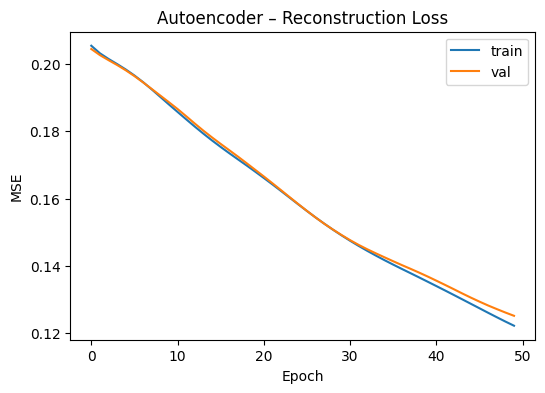

In [20]:
# Step 17: Autoencoder training curves

plt.figure(figsize=(6,4))
plt.plot(history_ae.history["loss"], label="train")
plt.plot(history_ae.history["val_loss"], label="val")
plt.title("Autoencoder – Reconstruction Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


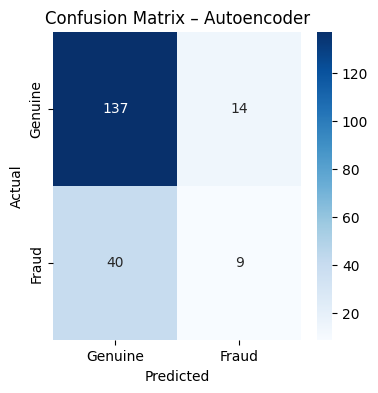

In [21]:
# Step 18: Confusion matrix – Autoencoder

plot_confusion(y_test, y_pred_ae, "Confusion Matrix – Autoencoder")


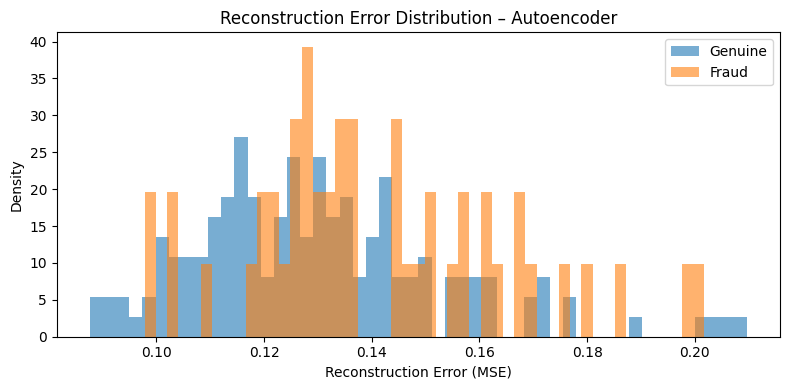

In [22]:
# Extra Plot 5: Reconstruction error distribution by class (Autoencoder)

plt.figure(figsize=(8, 4))

# Genuine
plt.hist(test_mse[y_test == 0], bins=50, alpha=0.6, label="Genuine", density=True)
# Fraud
plt.hist(test_mse[y_test == 1], bins=50, alpha=0.6, label="Fraud", density=True)

plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Density")
plt.title("Reconstruction Error Distribution – Autoencoder")
plt.legend()
plt.tight_layout()
plt.show()
